# **Group 9444 Pro Max**
|Name|StudentID|
|---|---|
|Siyuan Wu | z5412156|
|Yinru Sun | z5496029|
|Ruowen Ma | z5364549|
|Huangsheng Shi | z5431671|
|Haonan Peng | z5391150|


# **Introduction**

## **Project Objectives**
In this project, the team aims to enhance the performance of pre-existing image caption generating models. Specifically, the model employed for this purpose is CLIP (Contrastive Language-picture Pre-training). One of the main features of CLIP is its capacity for zero-shot learning, in which it demonstrates the capability to recognise and categorise images within classes that it has not received explicit training on. Nevertheless, CLIP does possess a drawback in terms of its ability to generalise effectively to images that are not included in its pretraining dataset [2]. Hence, the objective of the group is to improve the generalisation abilities of CLIP on unfamiliar datasets through appropriate data preprocessing and experimenting with layer alternation in the model.

# **Environment**
For the Dataset and Preprocessing demonstration

## **Install**

In [ ]:
!pip install pycocotools

## **Import**

In [1]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, CenterCrop, ToTensor, Normalize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO
from PIL import Image
import string

## **Data**

In [10]:
from google.colab import drive
drive.mount('/content/drive')
BASE_PATH= '/content/drive/MyDrive/CLIP_prefix_caption/data/coco'
#BASE_PATH='/CLIP_prefix_caption/data/coco'
train_img_path=os.path.join(BASE_PATH,'train2017')
anno_path=os.path.join(BASE_PATH,'annotations')
train_ann_path=os.path.join(anno_path,'captions_train2017.json')
train_cat_path=os.path.join(anno_path,'instances_train2017.json')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Dataset**
The **[COCO](https://cocodataset.org/#home)** (Common Objects in Context）dataset is a large-scale dataset with a diverse range of images from a variety of categories.It's provided by Microsoft Teams. It designed for object detection, segmentation, and captioning. In this project, we use **COCO 2017 Train/Val** dataset which contains 118,287 train images, 591,435 train annotations and 5000 val images, 25,000 val annotations. It contains 80 categories of images, and each image contains 5 annotations.

The dataset contains three folders: `train2017`, `val2017`, and `annotations`.Its annotation files are stored in the `annotations` folder using JSON format, and there are 3 types in total, each type contains training and validation, which share the images in the `train2017` and `val2017` folders. Our project mainly uses `captions_train2017/val2017.json` and `instances_train2017/val2017.json`. And the images, categories and annotations information store in a list in the file.

## **Example**

### Initialization

In [3]:
coco_train=COCO(train_ann_path)
cat_train=COCO(train_cat_path)
train_id=coco_train.getImgIds()
train_img=coco_train.loadImgs(train_id)


loading annotations into memory...
Done (t=3.62s)
creating index...
index created!
loading annotations into memory...
Done (t=30.60s)
creating index...
index created!


### The format of an image in JSON
Important information:

*   file_name: image file name
*   height: height of image
*   width: width of image
*   id: image id(Unique)

In [4]:
train_img[5]

{'license': 3,
 'file_name': '000000574769.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000574769.jpg',
 'height': 640,
 'width': 480,
 'date_captured': '2013-11-14 17:07:59',
 'flickr_url': 'http://farm8.staticflickr.com/7010/6728227647_3d5a0d55ee_z.jpg',
 'id': 574769}

the height and width of the image may not be the same.

### The format of an annotation in JSON
Important information:

*   image_id: image id(Corresponding to a unique image)
*   id: annotation id(Unique)
*   caption: annotaition

In [ ]:
ann_id=coco_train.getAnnIds(train_id[5])
anns=coco_train.loadAnns(ann_id)
anns

[{'image_id': 574769,
  'id': 561237,
  'caption': 'A woman in a room with a cat.'},
 {'image_id': 574769,
  'id': 562344,
  'caption': 'A girl smiles as she holds a cat and wears a brightly colored skirt.'},
 {'image_id': 574769,
  'id': 564249,
  'caption': 'a woman is holding a cat in her kitchen'},
 {'image_id': 574769,
  'id': 564444,
  'caption': 'A woman is working in a kitchen carrying a soft toy.'},
 {'image_id': 574769,
  'id': 564477,
  'caption': 'A woman is holding a cat in her kitchen.'}]

### The format of a category in JSON
Important information:

*   id: category id(Unique)
*   name: category name

In [ ]:
cat_id=cat_train.getCatIds()
print(cat_train.loadCats(cat_id[1]))


[{'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}]


### The image with its caption

A woman in a room with a cat.
A girl smiles as she holds a cat and wears a brightly colored skirt.
a woman is holding a cat in her kitchen
A woman is working in a kitchen carrying a soft toy.
A woman is holding a cat in her kitchen.


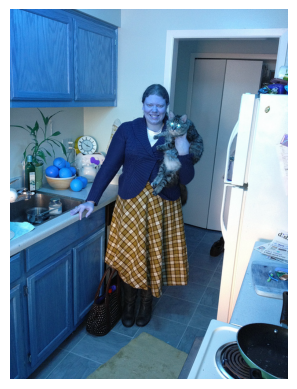

In [ ]:
annid=coco_train.getAnnIds(train_id[5])
anns=coco_train.loadAnns(annid)
coco_train.showAnns(anns)
img_path=os.path.join(train_img_path,"{:012d}.jpg".format(train_id[5]))
pic=cv2.imread(img_path)
plt.imshow(pic)
plt.axis('off')
plt.show()

The 5 annotations for each image are different.

# **Preprocessing**
Our preprocessing consists of text preprocessing and image preprocessing, we preprocessed the data and select wanted size to generate the .pkl fil, which will be needed for training later.

## **Text Preprocessing**

We preprocess the annotation, which includes:

*   Punctuation removal
*   Convert to lower case
*   Remove hanging 's
*   Remove string like numbers

By removing punctuation and converting text to lowercase, we can make our dataset more uniform, this helps to simplify the dataset, because it may be considered as noise. Removing the hanging 's can help us focus attention on the core content, and reduce the additional complexity introduced.

In [ ]:
annid=coco_train.getAnnIds(train_id[5])
anns=coco_train.loadAnns(annid)
print('Before:')
coco_train.showAnns(anns)

#code in parse_coco.py
clean_captions=anns
table = str.maketrans('','',string.punctuation)  #remove all punctuation
for j in range(len(clean_captions)):
    sentence = clean_captions[j]['caption'].replace("-"," ")
    # remove punctuation
    sentence = sentence.translate(table)
    split_sentence = sentence.split()
    # convert all to lower case
    split_sentence = [wrd.lower() for wrd in split_sentence]
    # remove 's and a that does not help with training
    split_sentence = [wrd for wrd in split_sentence if(len(wrd)>1)]
    # remove all string like numbers
    split_sentence = [wrd for wrd in split_sentence if(wrd.isalpha())]
    sentence = ' '.join(split_sentence)
    clean_captions[j]['caption'] = sentence


print('After:')
coco_train.showAnns(clean_captions)

Before:
A woman in a room with a cat.
A girl smiles as she holds a cat and wears a brightly colored skirt.
a woman is holding a cat in her kitchen
A woman is working in a kitchen carrying a soft toy.
A woman is holding a cat in her kitchen.
After:
woman in room with cat
girl smiles as she holds cat and wears brightly colored skirt
woman is holding cat in her kitchen
woman is working in kitchen carrying soft toy
woman is holding cat in her kitchen


## **Image preprocessing**

We will modify the preprocessing function of the image to improve model performance. Preprocessing includes:
*   **Random Horizontal Flip:**
The image will be randomly flipped horizontally with a value as a probability.
*   **Random Vertical Flip:**
The image will be randomly flipped vertically with a value as a probability.
*   **CLAHE(Contrast Limited Adaptive Histogram Equalization):**
Enhance local contrast in images and capture dark and light details of an image
*   **Convert Image To RGB:**
Ensure that all input images are in the RGB color space
*   **Other:**
Includes resizing the image to a fixed size, centering the crop to focus on the central region, normalizing pixel values to a standard range for model compatibility, and converting the image to a tensor format.


```
#code in parse_coco.py
n_px=224
def _transform(n_px):
    return Compose([
        Resize(n_px, interpolation=BICUBIC),
        RandomHorizontalFlip(0.2),
        RandomVerticalFlip(0.1),
        CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
        CenterCrop(n_px),
        _convert_image_to_rgb,
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])
def _convert_image_to_rgb(image):
    return image.convert("RGB")

```

By preprocessing the image, we can improve the robustness of the model and reduce overfitting, which is beneficial for the model to recognize the light and dark features in the image, and improves the model performance, so that the model can better recognize the image from all angles.


The following is a demonstration of some main part of the preprocessing steps.

**Random Horizontal and Vertical Flip:**We set it to flip horizontally with a probability of 0.2 and vertically with a probability of 0.1, which means that close to 20% and 10% of the image will be flipped horizontally or vertically, and 2% will be flipped both .

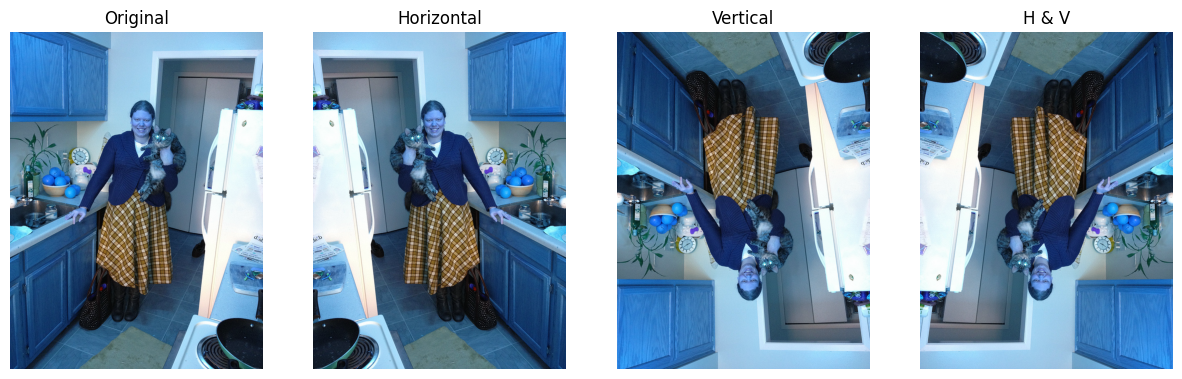

In [11]:
fig,axs=plt.subplots(1,4,figsize=(15,5))

process1=RandomHorizontalFlip(1)
process2=RandomVerticalFlip(1)
process3=Compose([RandomHorizontalFlip(1),RandomVerticalFlip(1)])
id=train_id[5]
img_path=os.path.join(train_img_path,"{:012d}.jpg".format(id))
image=cv2.imread(img_path)
image = Image.fromarray(image)
image1=process1(image)
image2=process2(image)
image3=process3(image)

axs[0].imshow(image)
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(image1)
axs[1].set_title('Horizontal')
axs[1].axis('off')
axs[2].imshow(image2)
axs[2].set_title('Vertical')
axs[2].axis('off')
axs[3].imshow(image3)
axs[3].set_title('H & V')
axs[3].axis('off')

plt.show()

**CLAHE(Contrast Limited Adaptive Histogram Equalization):**CLAHE processes small areas of the image to make the overall contrast of the image more balanced by limiting the contrast, and the visibility of detailed features is increased.

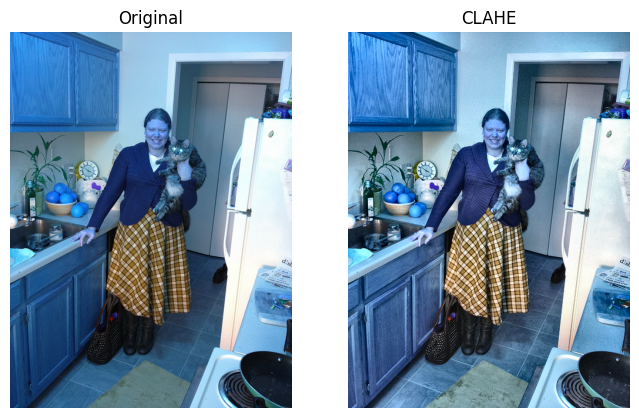

In [12]:
class CLAHETransform(object):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def __call__(self, img):
        img = np.array(img)  # Convert PIL image to numpy array
        if len(img.shape) == 2:  # If image is grayscale
            img = self.clahe.apply(img)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(img)
            l = self.clahe.apply(l)
            img = cv2.merge((l, a, b))
            img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
        img = Image.fromarray(img)  # Convert numpy array back to PIL image
        return img

process4=CLAHETransform()
image4=process4(image)

fig,axs=plt.subplots(1,2,figsize=(8,5))
axs[0].imshow(image)
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(image4)
axs[1].set_title('CLAHE')
axs[1].axis('off')
plt.show()

We can see the details in its darker areas become brighter, such as the bag around the feet. So we can know that CLAHE can give us better detail, enhance features and prevent noise amplification.

CLAHE also has many obvious defects, like the image noise amplification, the overall brightness appears to change significantly.

# **Model and Methods**

Firstly, we get the training folders from github by the below order:


In [ ]:
!git clone https://github.com/rmokady/CLIP_prefix_caption && cd CLIP_prefix_caption

and then downloading necessary packages:

In [ ]:
!pip install scikit-image==0.19.0 ftfy regex tqdm
!pip install --upgrade transformers tokenizers
!pip install git+https://github.com/openai/CLIP.git
!pip install sacrebleu
!pip install Rouge

Next, download coco train、validation、annotation dataset and unzip them to the target directory here:

In [ ]:
# Create necessary directories
!mkdir -p data/coco/annotations

# Download train_captions to data/coco/annotations.
# (Assuming the file is publicly accessible, replace 'train_captions_url' with the actual URL)
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O data/coco/annotations/annotations_trainval2017.zip
!unzip data/coco/annotations/annotations_trainval2017.zip -d data/coco/annotations/

# Download and unzip training and validation images
# (Replace 'training_images_url' and 'validation_images_url' with the actual URLs)
!wget http://images.cocodataset.org/zips/train2017.zip -O data/coco/training_images.zip
!wget http://images.cocodataset.org/zips/val2017.zip -O data/coco/validation_images.zip
!unzip data/coco/training_images.zip -d data/coco/
!unzip data/coco/validation_images.zip -d data/coco/

Knowing we have downloaded PrefixCaption, we should replace the original `parse_coco.py` and `train.py` in the PrefixCaption folder with the uploaded ones in the .zip.

`parse_coco.py` is used for data preprocessing, and train.py is to train the clip model. In the stage of processing, we use 'RN50', 'RN101', 'RN50x4', 'ViT-B/32' as pretrained image processing models and GPT-2 as text processing model. Then we need to make train.py compatible with `parse_coco.py`. Therefore, we nomiate different parse_coco or train names like `parse_coco_RN50.py` and `train_RN50.py` for a more concise programming and testing.

Then, we need to get insight of parse_coco.py, so we use chuncks of code of `parse_coco.py` for the explaination of different functions.

The first part of `parse_coco.py` function is cbam(Convolutional Block Attention Module),This module consists of channel attention and spacial attention.The code is below:


class ChannelAttention(nn.Module):
---
    def __init__(self, num_channels, reduction_ratio=8):
        super(ChannelAttention, self).__init__()
        self.num_channels = num_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.shared_MLP = nn.Sequential(
            nn.Linear(num_channels, num_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(num_channels // reduction_ratio, num_channels)
        )
        
    def forward(self, x):
        avg_pool = self.avg_pool(x).view(-1, self.num_channels)
        max_pool = self.max_pool(x).view(-1, self.num_channels)
        avg_out = self.shared_MLP(avg_pool)
        max_out = self.shared_MLP(max_pool)
        out = avg_out + max_out
        scale = torch.sigmoid(out).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

class SpatialAttention(nn.Module):
---
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdims=True)
        max_out, _ = torch.max(x, dim=1, keepdims=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
---
    def __init__(self, num_channels, reduction_ratio=8, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(num_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)
        
    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

The channel attention mechanism aboove learns to emphasize important channels and suppress less useful ones in the feature map. By processing global average and max pooled information, the network can identify which channels are more informative for a given input. The shared MLP allows for a non-linear transformation of this information, and the combination of average and max pooling ensures that both the most common (average) and the most salient (max) features are considered in determining the importance of each channel.

The spatial attention mechanism works by generating a spatial attention map that can be used to weigh the importance of different spatial regions in the input feature map. It does this by considering both the average and maximal information across the feature channels and then applying a convolution to mix these features. The output, after the sigmoid activation, provides a normalized attention map where higher values indicate regions of greater importance.

Then, we put cbam inside clip model, the code is below:

class ModifiedCLIP(torch.nn.Module):
---
    def __init__(self, original_clip_model, cbam):
        super(ModifiedCLIP, self).__init__()
        self.visual = original_clip_model.visual
        self.cbam = cbam
        #self.proj = original_clip_model.visual.proj

    def forward(self, image):
        x = self.visual.conv1(image)
        x = self.visual.bn1(x)
        x = self.visual.relu1(x)
        
        x = self.visual.conv2(x)
        x = self.visual.bn2(x)
        x = self.visual.relu2(x)
        
        x = self.visual.conv3(x)
        x = self.visual.bn3(x)
        x = self.visual.relu3(x)
        
        x = self.visual.avgpool(x)  # Using the avgpool layer as per your model structure
        
        # Continue with the subsequent layers
        x = self.visual.layer1(x)
        x = self.visual.layer2(x)
        x = self.visual.layer3(x)
        x = self.visual.layer4(x)

        # Apply CBAM after layer4
        x = self.cbam(x)

        # Assuming attnpool is a method of aggregating the features in the transformer architecture
        x = self.visual.attnpool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        #x = self.visual.proj(x)

        return x
    
    def encode_image(self, image):
        image = image.half()
        return self.forward(image)

We can see cbam after layer4 before attention pool where this module mainly optimize the data before output. We think clip model is complex enough to learn so we do not need to add layers in the first consecutive layers of the model. Therefore, we unforzen the last layers of the model to be trainable. This unforzen operation code below is in def main fuction:


    # Unfreeze layers starting from the last 'layer3' block and all 'layer4' blocks
    cbam = CBAM(2048)

    clip_model = ModifiedCLIP(clip_model, cbam).to(device)
    for name, parameter in clip_model.visual.named_parameters():
       if 'layer3.5' in name or 'layer4' in name or 'attnpool' in name:
         parameter.requires_grad = True
       else:
         parameter.requires_grad = False


In `train.py`, we write code for computing, printing and plotting metrics(rouge, bleu, validation loss, perplexity and meteor):

def compute_metrics(references, hypotheses, val_loss):
    
    # Tokenize the hypotheses and references
    hypotheses_tokens = [hyp.split() for hyp in hypotheses]
    references_tokens = [[ref.split() for ref in ref_group] for ref_group in references]
    
    # Convert references back to string format for rouge scoring
    references_str = [' '.join(ref_group[0]) for ref_group in references_tokens]
    
    # For BLEU
    smoothie = SmoothingFunction().method4
    bleu_score = corpus_bleu(references_tokens, hypotheses_tokens, smoothing_function=smoothie)
    
    # For ROUGE
    rouge = Rouge()
    rouge_scores = rouge.get_scores(hypotheses, references_str, avg=True)
    rouge_l = rouge_scores['rouge-l']['f']
    
    # For METEOR
    meteor_scores = [meteor_score.single_meteor_score(ref.split(), hyp.split()) for ref, hyp in zip(references_str, hypotheses)]
    meteor = sum(meteor_scores) / len(meteor_scores)
    
    # Compute Perplexity from Validation Loss
    perplexity = torch.exp(torch.tensor(val_loss)).item()
    
    return bleu_score, rouge_l, val_loss, perplexity, meteor




Printing and plotting


        #Begin validation evaluation
        model.eval()
        val_loss = 0
        references = []
        hypotheses = []

        for idx, (tokens, mask, prefix) in enumerate(val_dataloader):
            tokens, mask, prefix = tokens.to(device), mask.to(device), prefix.to(device, dtype=torch.float32)

            with torch.no_grad():
                outputs = model(tokens, prefix, mask)

            logits = outputs.logits[:, dataset.prefix_length - 1: -1]

            val_loss += nnf.cross_entropy(logits.reshape(-1, logits.shape[-1]), tokens.flatten(), ignore_index=0).item()
            preds = torch.argmax(logits, dim=-1).cpu().numpy()

            for i in range(preds.shape[0]):
                ref_caption = dataset.captions[idx * batch_size + i]
                hyp_caption = tokenizer.decode(preds[i], skip_special_tokens=True)
                references.append([ref_caption])
                hypotheses.append(hyp_caption)

        val_loss /= len(val_dataloader)
        bleu, rouge, v_loss, perplexity, meteor = compute_metrics(references, hypotheses, val_loss)

        print(f"Epoch {epoch}: BLEU: {bleu}, ROUGE: {rouge}, Val Loss: {v_loss}, Perplexity: {perplexity}, METEOR: {meteor}")

        # Append the metric values for this epoch to the lists
        bleu_scores.append(bleu)
        rouge_scores.append(rouge)
        val_losses.append(v_loss)
        perplexities.append(perplexity)
        meteor_scores.append(meteor)

        model.train()

        # End validation evaluation
        if epoch % args.save_every == 0 or epoch == epochs - 1:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-{epoch:03d}.pt"),
            )

    # After the training loop, create plots for each metric
    epochs_range = range(epochs)

    plt.figure(figsize=(10, 6))
    plt.subplot(2, 3, 1)
    plt.plot(epochs_range, bleu_scores, label='BLEU')
    plt.legend(loc='upper right')
    plt.title('BLEU Score')

    plt.subplot(2, 3, 2)
    plt.plot(epochs_range, rouge_scores, label='ROUGE')
    plt.legend(loc='upper right')
    plt.title('ROUGE Score')

    plt.subplot(2, 3, 3)
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Validation Loss')

    plt.subplot(2, 3, 4)
    plt.plot(epochs_range, perplexities, label='Perplexity')
    plt.legend(loc='upper right')
    plt.title('Perplexity')

    plt.subplot(2, 3, 5)
    plt.plot(epochs_range, meteor_scores, label='METEOR')
    plt.legend(loc='upper right')
    plt.title('METEOR Score')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_metrics.png'))
    plt.show()


Next, we initially need to execute instructions of `parse_coco.py` below:

In [ ]:
!python CLIP_prefix_caption/parse_coco.py --clip_model_type RN50 #RN101 RN50x4 Vit-B/32  model selected as needed, but Vit-B/32 is used for DAT not cbam, and it is incompatible with cbam

The above code is parse training data, if we want to parse validation data, we use:


In [ ]:
!python CLIP_prefix_caption/parse_coco.py --clip_model_type RN50 --is_val True #RN101 RN50x4 Vit-B/32  model selected as needed, but Vit-B/32 is not used for DAT not cbam, and it is incompatible with cbam

Then we execute instructions of train.py below, using the generated .pkl by parse instructions above:

In [ ]:
#Here is just the example of using RN50, RN101 RN50x4 Vit-B/32 is selected as needed, but Vit-B/32 is not used for DAT not cbam, and it is incompatible with cbam
!python /content/CLIP_prefix_caption/train.py --data /content/data/coco/oscar_split_RN50_train.pkl --val_data /content/data/coco/oscar_split_RN50_val.pkl --out_dir /content/coco_train/

Hence, we collect the results from training instruction to plot the comparative evaluation metrics showing the trend of different models

# **Results**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

Import the trained data and evaluate each model through the line chart and the average value of the indicators.

In [ ]:
def generate_combined_line_chart(file_path):
    # Read the Excel file into a DataFrame
    df = pd.read_excel(file_path)
    # Extract curve names from the first column
    curve_names = df.iloc[:, 0].unique()
    # Plot all curves on a single line chart
    plt.figure(figsize=(10, 6))
    for curve_name in curve_names:
        selected_data = df[df.iloc[:, 0] == curve_name].iloc[:, 1:].values.flatten()
        plt.plot(range(2, len(selected_data) + 2), selected_data, marker='o', label=curve_name)

    plt.title("Bleu")
    # plt.xlabel(" ")
    # plt.ylabel(" ")
    plt.grid(True)
    plt.legend()
    plt.show()

file_path = 'D:/pycharm/np/blue.xlsx'# this .xlsx collects data points got from training results, the directory is our own, you should change as your own.
generate_combined_line_chart(file_path)

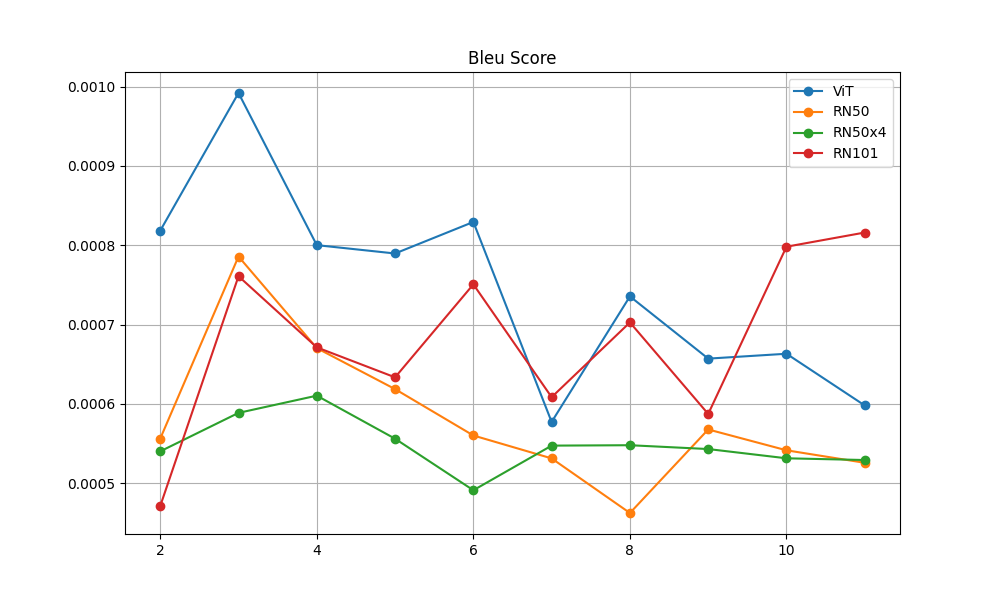

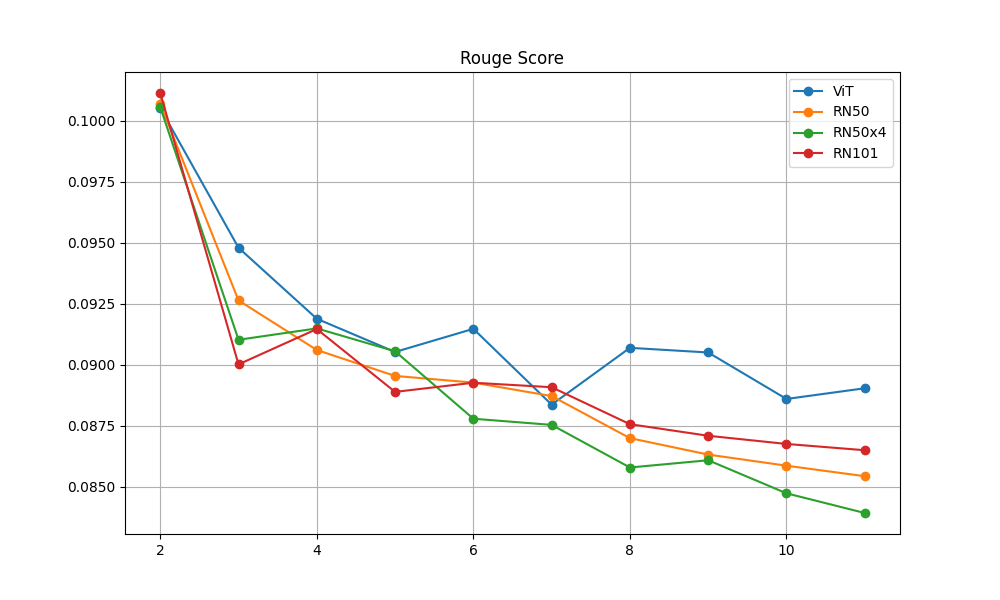

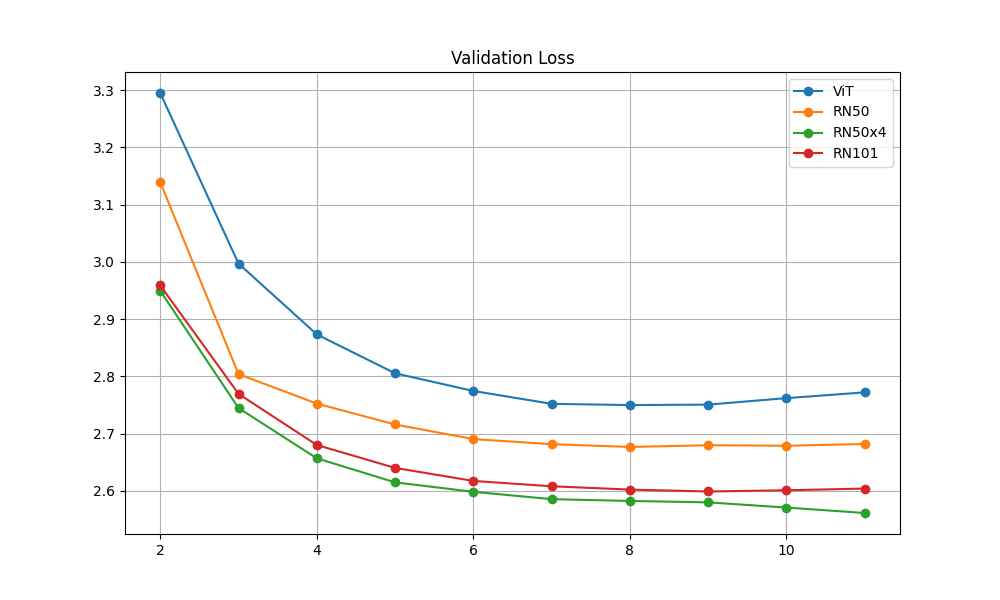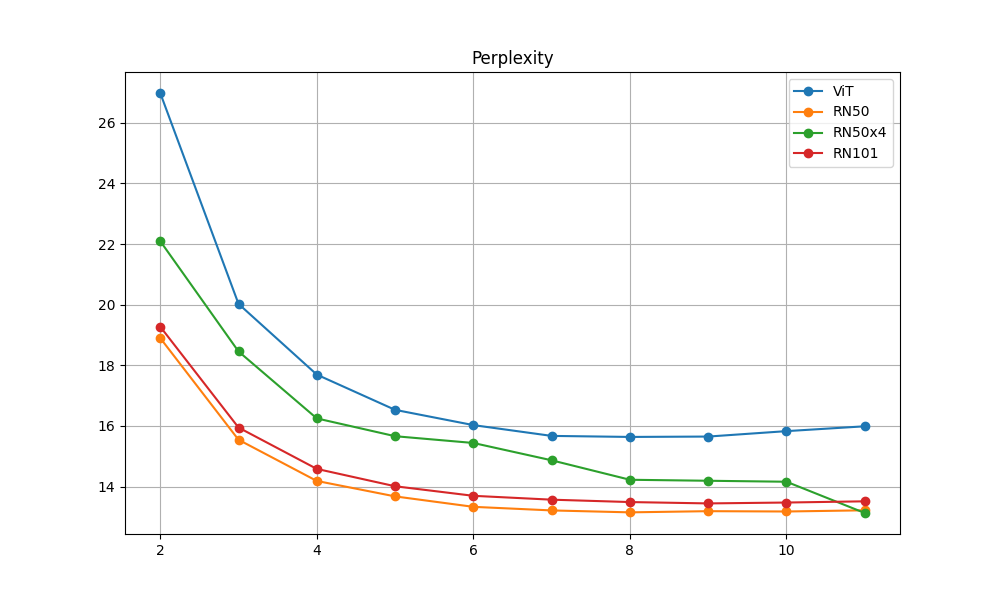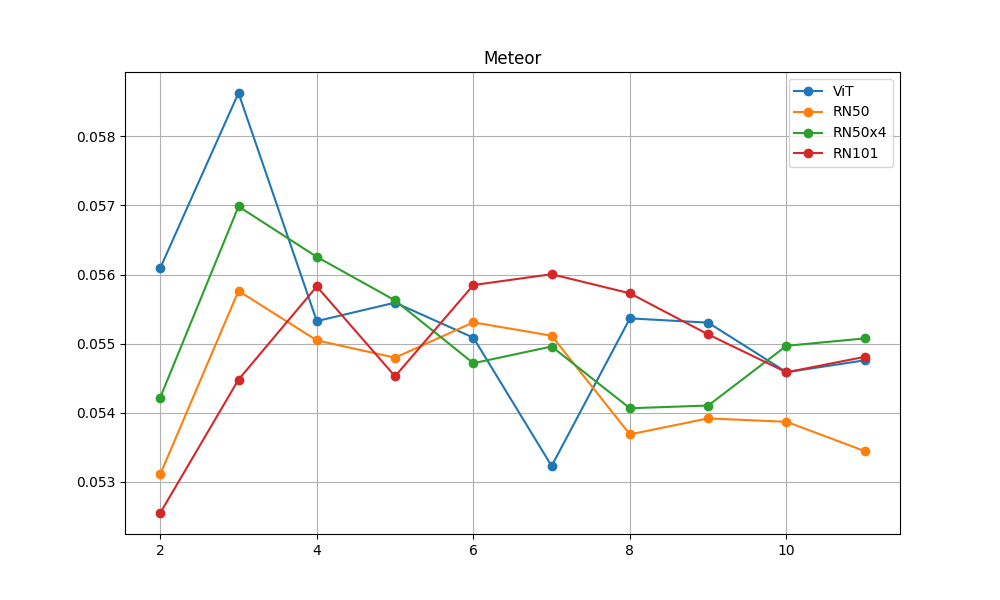

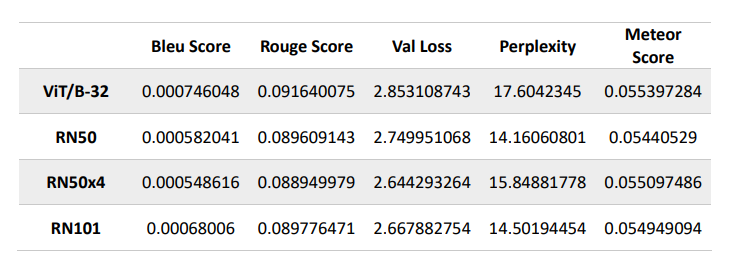

The average of the indicators in the four models

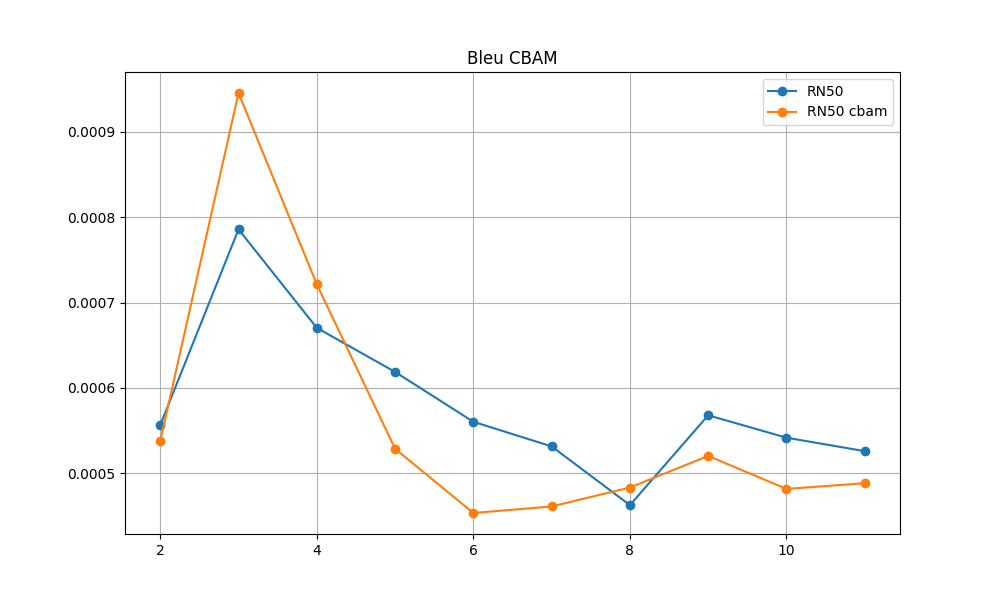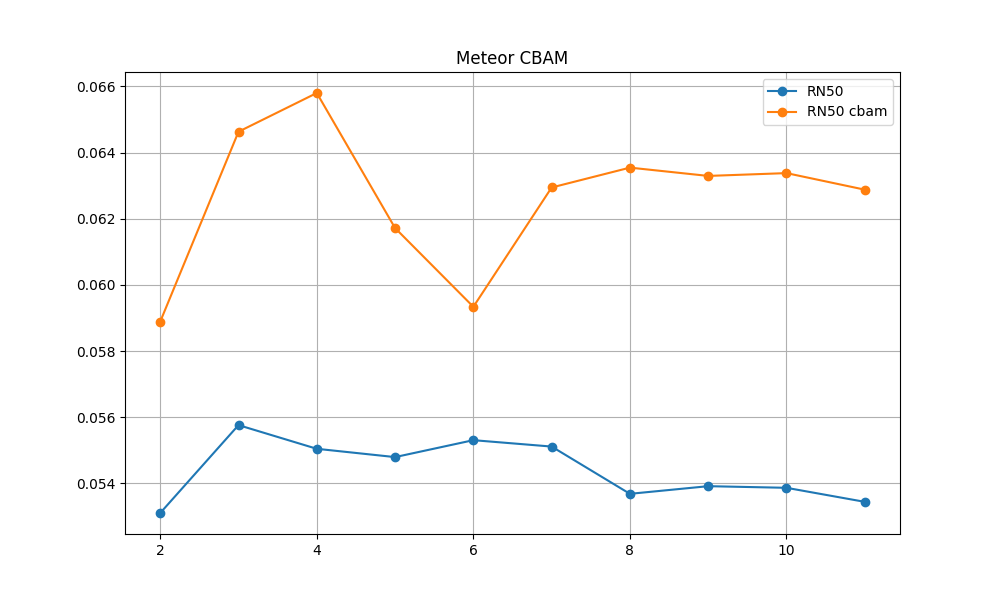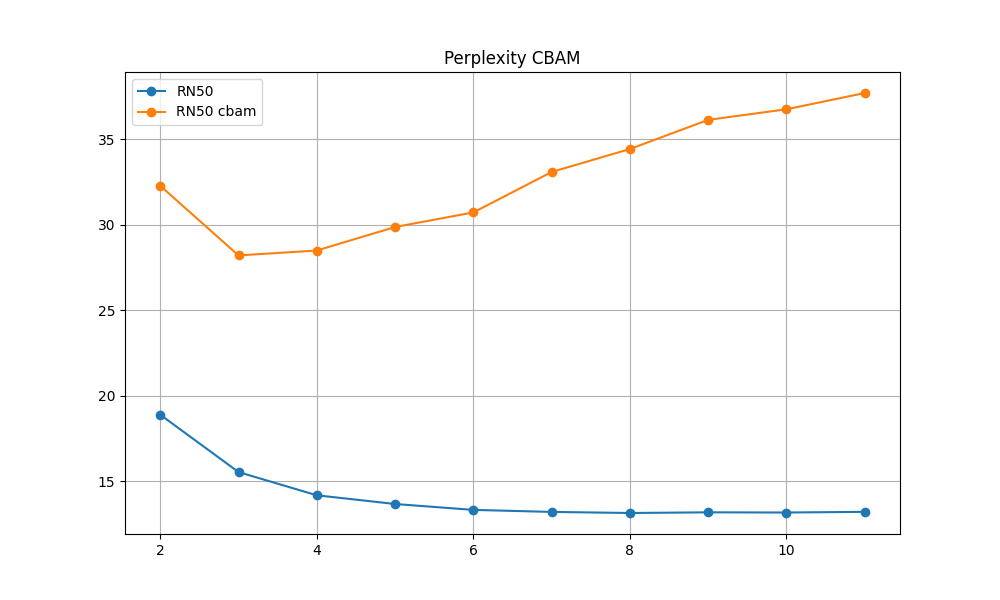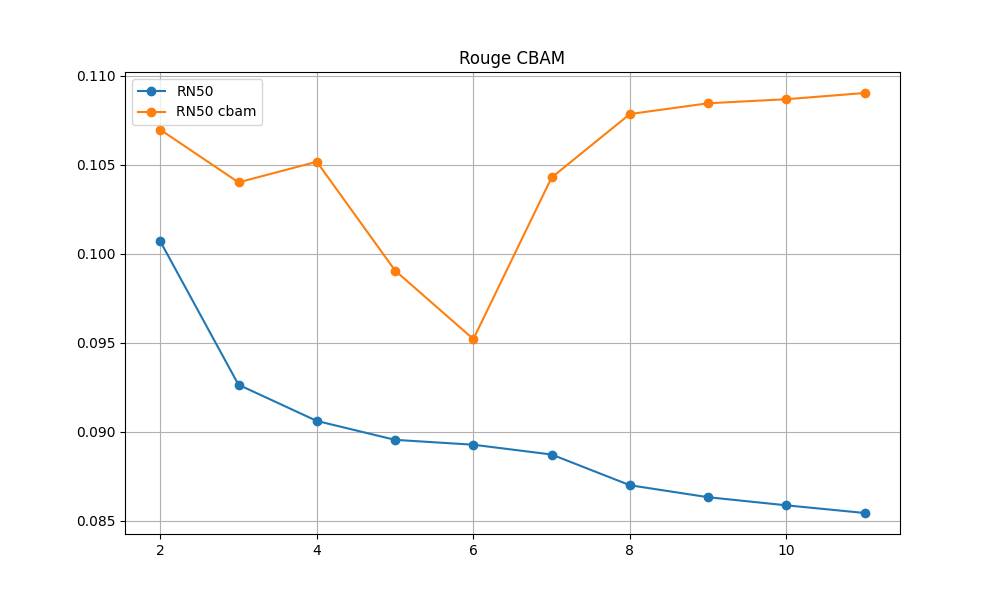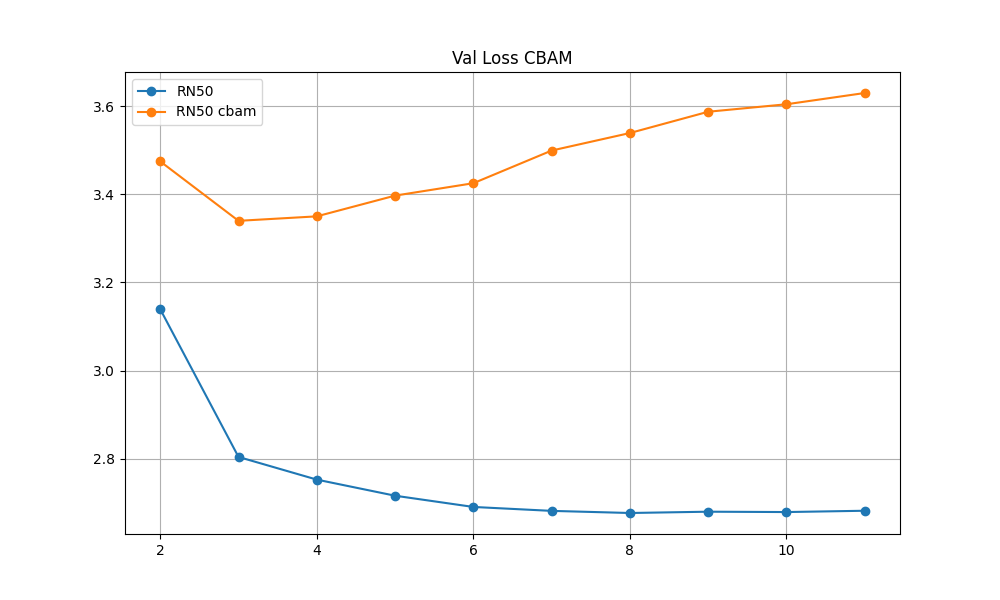

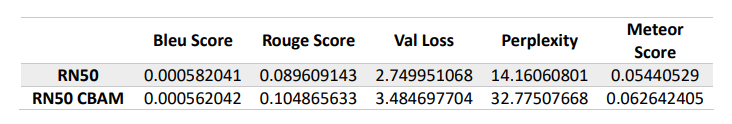

Changes in various indicators in the RN50 model after using CBAM

## **Metrics explanation**

**BLEU (Bilingual Evaluation Understudy):**

BLEU scores range from 0 to 1, where 1 indicates a perfect match with the reference captions. In practice, scores are often reported in percentage form (0-100).

A higher BLEU score indicates better correspondence with the reference captions. In image captioning, a BLEU score above 0.4 (or 40%) is generally considered good, but this can vary depending on the dataset and the complexity of the task.

**METEOR (Metric for Evaluation of Translation with Explicit Ordering):**

METEOR scores also range from 0 to 1, with 1 being the perfect score.

METEOR is considered more advanced than BLEU as it accounts for synonyms and stemming, and has a higher correlation with human judgment. Scores around 0.3 (or 30%) and above are often seen as good in image captioning, but again, this depends on the specific context and dataset.

**ROUGE (Recall-Oriented Understudy for Gisting Evaluation):**

ROUGE is primarily used for evaluating text summarization. ROUGE-L, which focuses on the longest common subsequence, is often used in captioning tasks. Like BLEU and METEOR, ROUGE scores range from 0 to 1.

A ROUGE score above 0.5 (or 50%) is usually considered decent, but optimal scores can vary.

**For BLEU, METEOR and METEOR:**

Our result is far from the target value. That's because zero-shot training for CLIP model requires about 400 million image-text pairs to get a effective result, Due to constraints of computing resource, we choose about 110,000 image-text pairs as training dataset and the limited training dataset leads to low precision and recall.

**For validation loss and perplexity:**

We found that too many epochs with small trainnig dataset would lead overfitting, so we reduce the epochs number to 10 to reduce overfitting problem.

**Application of CBAM and Unfrozen operation:**

Due to computing resource constraints, we opted for the lightweight RN50 to implement these techniques.

With CBAM: The aim of CBAM is to provide a more refined attention mechanism that helps the model focus on the most meaningful features in the data. The stable but not improving validation loss and other metrics might suggest that CBAM is indeed preventing the model from overfittingby not allowing it to fit too closely to the training data.owever. this also raises the question of whether the model is underfitting or if there's another issue at play, such as insufficient training or inappropriate hyperparameter settings.

Without CBAM: The clear improvements initially followed by declines in performance metrics suggest that the model may learn effectively at first but then starts to overfit. The absence of anattention mechanism like CBAM might be allowing the model to pay equal attention to all features,including those that lead to overfitting.

**Summary**

We do obtain the improvement on Rouge score and meteor score after applying CBAM and unfrozen layers. However, the stable but not improving validation loss and perplexity might suggest that CBAM is indeed preventing the model from overfitting by not allowing it to fit too closely to the training data.



# **Discussion**

**Strengths:**


*   CBAM: Enhances feature representation by focusing on important regions (spatial
attention) and relevant channels (channel attention). This leads to more contextually rich captions as the model focuses on significant parts of the image, which prevents overfitting by not allowing it to fit too closely to the training data.

*  Transfer Learning with RN50: Beneficial because RN50 is trained on a vast dataset (ImageNet), enabling it to recognize a wide range of visual patterns, which is crucial for understanding diverse images in captioning tasks.


**Weaknesses:**


*   Data Constraints: Limited datasets might not represent the variety and complexity of real-world scenes, causing the model to not learn enough diverse patterns (underfitting).
*   Overfitting: Training on a small dataset may cause the model to memorize specific data patterns, reducing its ability to generalize to new, unseen data.


**Limitations:**



*   Resource Limitations: High computational demand for training large models like CLIP with CBAM on extensive datasets may not be feasible for all.
*   CBAM's Limited Efficacy: In scenarios with limited data, CBAM’s ability to enhance the feature extraction might be restricted.



**Future Work:**



*   Advanced Data Augmentation: Implementing techniques like GAN-based synthetic data generation or advanced geometric transformations to create a more diverse training set.

*   Incorporating DAT in ViT: Implementing Deformable Attention Transformers (DAT) within the ViT structure could offer enhanced feature extraction and improved attention mechanisms. DAT's dynamic attention could help in better understanding complex image contexts, potentially addressing the overfitting issue by focusing more on generalizable features.

*  Switching to BLIP from CLIP:BLIP's Advantages: BLIP (Bootstrapped Language Image Pretraining) is designed to improve image-text alignment, which is fundamental for captioning tasks. It leverages both image-text and text-only data during training, potentially leading to better language understanding and caption generation. CLIP vs. BLIP: While CLIP excels in image-text matching, BLIP's training approach makes it more adept in understanding nuanced language contexts within images. This could result in more accurate and contextually rich captions.



* Ensemble Techniques: Combining models (e.g., a mix of CNNs and Transformers) to leverage their individual strengths, potentially improving accuracy and robustness against overfitting.
















